In [2]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from src import *

external_path=''

In [3]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, in_dimension: int, bias=True):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=torch.nn.Linear(in_dimension,1)
        self.sigmoid=torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

In [4]:
def get_dataset(positive_digit,negative_digit):
    positive_digit_activations=torch.load(f'{external_path}\\latent_activations\\{positive_digit}.pt')
    negative_digit_activations=torch.load(f'{external_path}\\latent_activations\\{negative_digit}.pt')

    latent_space_activations=torch.cat([positive_digit_activations,negative_digit_activations])

    dataset_size=positive_digit_activations.shape[0]+negative_digit_activations.shape[0]

    labels=torch.cat([torch.ones(positive_digit_activations.shape[0]),torch.zeros(negative_digit_activations.shape[0])])
    perm=torch.randperm(dataset_size)

    dataset=(latent_space_activations[perm].detach(),labels[perm].detach())
    return dataset

In [20]:
def train(dataset,batch_size=64,lr=1e-3,epochs=100,verbose=False):

    latent_space_dim=dataset[0].shape[1]
    dataset_size=dataset[0].shape[0]

    model=LinearClassifier(latent_space_dim)
    optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    criterion=torch.nn.BCELoss()

    if verbose:
        progress_bar=tqdm(range(epochs))
    else:
        progress_bar=range(epochs)

    for epoch in progress_bar:
        epoch_loss=0
        epoch_cycles=dataset_size//batch_size
        for k in range(epoch_cycles+1):
            optimizer.zero_grad()
            if k==epoch_cycles:
                inputs=dataset[0][-k*batch_size:]
                labels=dataset[1][-k*batch_size:]
            else:
                inputs=dataset[0][k*batch_size:(k+1)*batch_size]
                labels=dataset[1][k*batch_size:(k+1)*batch_size]
            outputs=model(inputs).reshape((len(labels),))
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()*len(labels)
        if verbose:
            progress_bar.set_description(f"Loss={epoch_loss/dataset_size:.4f}")
        if loss<1e-5 and epoch>=49:
            break

    return model,epoch_loss/dataset_size,epoch

In [7]:
def concept_vector(model):
    cav=model.linear.weight[0].detach()
    return cav/torch.norm(cav,p=2)

In [38]:
losses_file=open(f'{external_path}\\concept_activation_vectors\\losses.txt','w')

progress_bar=tqdm(range(10))

for positive_digit in progress_bar:
    for negative_digit in range(10):
        if positive_digit==negative_digit:
            continue
        progress_bar.set_description(f'...processing digit {positive_digit} ({negative_digit}/10)...')
        dataset=get_dataset(positive_digit,negative_digit)
        model,loss,epoch=train(dataset)
        cav=concept_vector(model)
        torch.save(cav,f'{external_path}\\concept_activation_vectors\\{positive_digit}_{negative_digit}.pt')

        losses_file.write(f'{positive_digit}-{negative_digit},{loss}\n')

losses_file.close()

...processing digit 9 (8/10)...: 100%|██████████| 10/10 [16:02<00:00, 96.26s/it] 


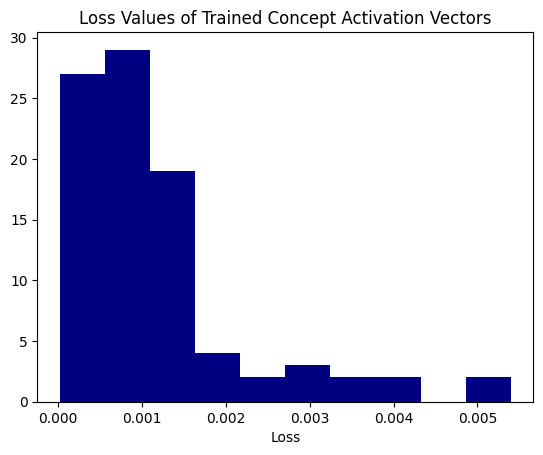

In [29]:
losses_file=open(f'{external_path}\\concept_activation_vectors\\losses.txt','r')
losses=[]
for line in losses_file.readlines():
    losses.append(float(line.split(',')[1][:-1]))
losses_file.close()
colors=plt.cm.jet(np.linspace(0,1,2))
plt.hist(losses,color=colors[0])
plt.title('Loss Values of Trained Concept Activation Vectors')
plt.xlabel('Loss')
plt.show()